# CNC SMS Prediction Perceptron Neuro Model

Иммется временной ряд отправленных СМС оповещений за 4 месяца с периодичнотью в 10 минут.
Требуется выдать прогноз на n временных интервалов вперед и визуализировать результаты испольуя многослойный персептрон

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras import regularizers

pd.options.display.float_format = '{:.3f}'.format

def create_neuro_sets(data, window=10, forecast=10, step=1, normalization=False):
    X, Y = [], []
    for i in range(0, len(data) - step - window - forecast, step):
        x_i = data[i: i + window]
        y_i = data[i + window + forecast]

        Y.append(y_i)
        X.append(x_i)

    if normalization:
        X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]

    return np.array(X), np.array(Y)

Using TensorFlow backend.


Загрузим входные данные, затем визуализируем их и выведем некоторые статистические показатели

Populating the interactive namespace from numpy and matplotlib


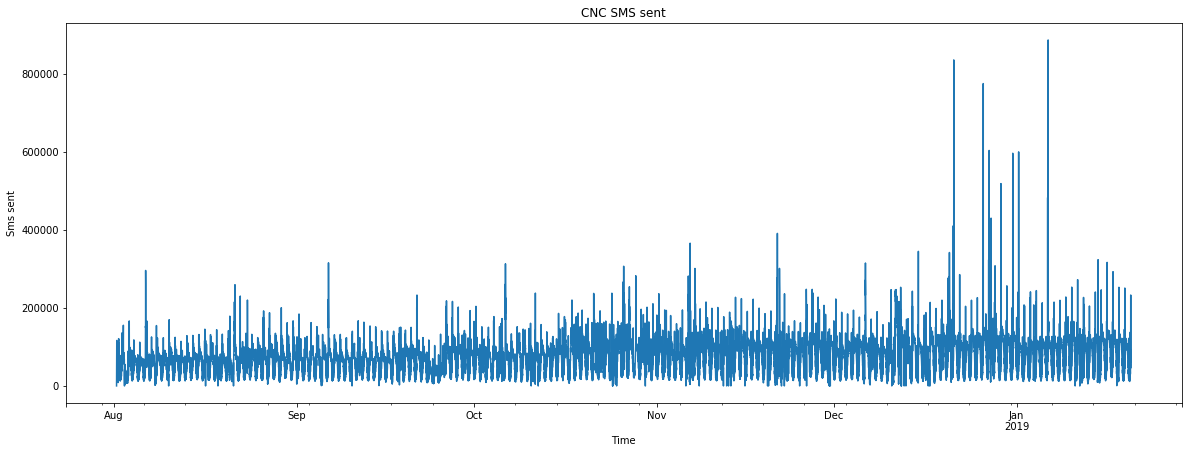

count    24768.000
mean     68637.886
std      42793.965
min          1.000
25%      30642.750
50%      68145.500
75%      96240.000
max     886752.000
Name: Value, dtype: float64

In [2]:
%pylab inline
df = pd.read_csv('10min.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min', method='pad')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')
plt.show()
    
data.describe()

#### Введем следующие параметры модели:  
**NUM_EPOCHS**  - сколько раз через модель прогонят всю обучающаю выборку  
**BATCH_SIZE** - по сколько примеров давать за раз  
**WINDOW** - размер временного окна  
**FORECAST**  - на сколько временных интревало вперед будем брать прогноз при составлении врменного окна  

In [24]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
WINDOW = 24
FORECAST = 1

Создадим множества X и Y  и разделим их на обучающую и тестовую выборки в соотношении 8/2

In [25]:
X, Y = create_neuro_sets(data, window=WINDOW, forecast=FORECAST, normalization=False)

validation_barrier = int(len(Y)*0.8)

Y_train = Y[:validation_barrier]
X_train = X[:validation_barrier]
Y_test = Y[validation_barrier:]
X_test = X[validation_barrier:]

В нашей архитектруе будет входной слой из 64 нейронов размерностью с окно прохода,  
Два скрытых слоя с дропаутом 0.5 между ними  
Данные бьудем подавать последовательно, без перемешки для сохранения свойств временной последовательности  
Так же введем колбэк *reduce_lr*, который будет уменьшать шаг градиентного спуска если ошибка вышла на плато
Функкцию активации возьмем *LeakyReLU*, которая равна:
$$f(x)={\begin{cases}x&{}x>0\\{\alpha}\cdot x&{}x\leq0\end{cases}}, \; где \; 0 < \alpha \ll 1$$

In [30]:
model = Sequential()
#*******************Input level**********************************
model.add(Dense(64, input_dim=WINDOW, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
#*******************Hidden level 1*********************************
model.add(Dense(128, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
#*******************Hidden level 2*********************************
model.add(Dense(128, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
#*******************Output level**********************************
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)

history = model.fit(X_train, Y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr]);


Train on 19793 samples, validate on 4949 samples
Epoch 1/100
19793/19793 [==============================] - 3s 153us/step - loss: 10621803554.5076 - acc: 5.0523e-05 - val_loss: 14421269892.3710 - val_acc: 2.0206e-04
Epoch 2/100
19793/19793 [==============================] - 2s 86us/step - loss: 6866214954.6300 - acc: 0.0000e+00 - val_loss: 11125243087.1174 - val_acc: 4.0412e-04
Epoch 3/100
19793/19793 [==============================] - 2s 78us/step - loss: 6166151453.7091 - acc: 0.0000e+00 - val_loss: 9645264683.3995 - val_acc: 0.0000e+00
Epoch 4/100
19793/19793 [==============================] - 1s 71us/step - loss: 5828812592.3856 - acc: 0.0000e+00 - val_loss: 8790942103.7171 - val_acc: 0.0000e+00
Epoch 5/100
19793/19793 [==============================] - 2s 83us/step - loss: 5610503678.7325 - acc: 0.0000e+00 - val_loss: 8500614660.2417 - val_acc: 0.0000e+00
Epoch 6/100
19793/19793 [==============================] - 2s 77us/step - loss: 5431988752.2320 - acc: 0.0000e+00 - val_loss: 8

Epoch 50/100
19793/19793 [==============================] - 2s 80us/step - loss: 704960227.8009 - acc: 0.0000e+00 - val_loss: 1432904072.1730 - val_acc: 0.0000e+00
Epoch 51/100
19793/19793 [==============================] - 2s 82us/step - loss: 704569679.4915 - acc: 1.0105e-04 - val_loss: 1466636582.9768 - val_acc: 2.0206e-04
Epoch 52/100
19793/19793 [==============================] - 2s 82us/step - loss: 711486922.8871 - acc: 0.0000e+00 - val_loss: 1687245655.1869 - val_acc: 0.0000e+00

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
Epoch 53/100
19793/19793 [==============================] - 2s 96us/step - loss: 699320350.7648 - acc: 5.0523e-05 - val_loss: 1656055431.0091 - val_acc: 0.0000e+00
Epoch 54/100
19793/19793 [==============================] - 2s 91us/step - loss: 685398808.9785 - acc: 0.0000e+00 - val_loss: 1454464308.8915 - val_acc: 0.0000e+00
Epoch 55/100
19793/19793 [==============================] - 2s 89us/step - loss: 689696603.2993 - a

Epoch 99/100
19793/19793 [==============================] - 2s 97us/step - loss: 668930292.8268 - acc: 0.0000e+00 - val_loss: 1454969487.2855 - val_acc: 0.0000e+00
Epoch 100/100
19793/19793 [==============================] - 2s 90us/step - loss: 669026643.4994 - acc: 0.0000e+00 - val_loss: 1573806001.5809 - val_acc: 0.0000e+00


Выведем данные обучения модели: ошибку и точность

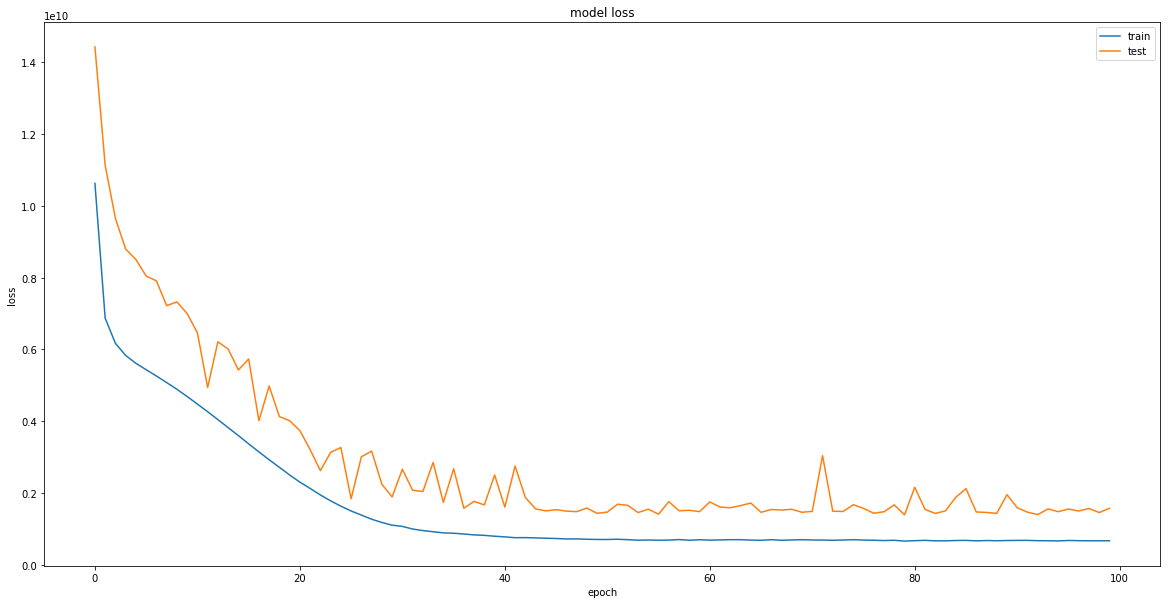

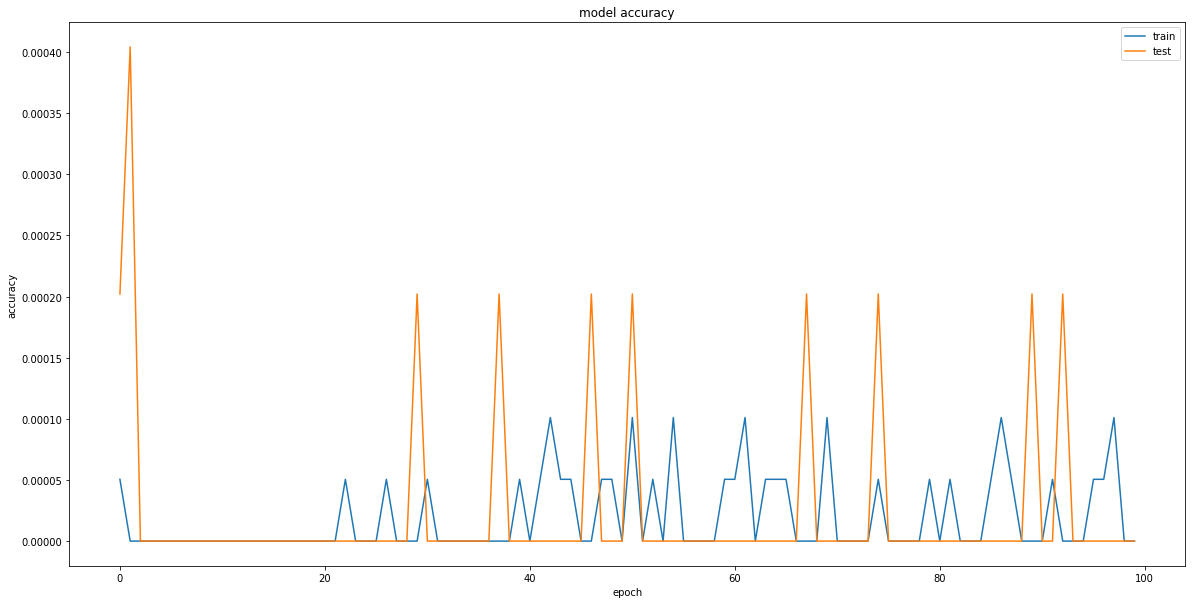

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Проверим коррекность нашей модели визуализировав результаты тестовой выборки

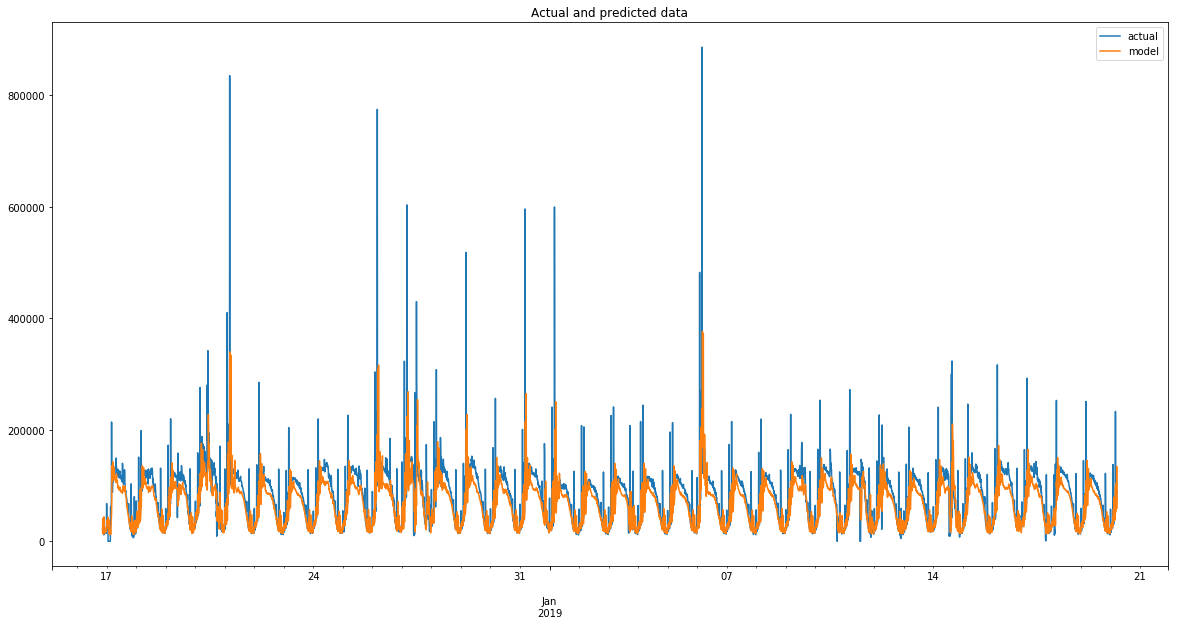

In [32]:
plt.figure(figsize(20,10))

pred = model.predict(X_test)

beg = data.index[validation_barrier]
end = data.index[-WINDOW-FORECAST-1-1]

dates = pd.date_range(start=beg, end=end, freq='10min')

predicted = pd.Series(np.squeeze(pred), index=dates)
actual = pd.Series(Y_test, index=dates)

actual.plot(label='actual')
predicted.plot(label='model')
plt.legend(loc='best')
plt.title('Actual and predicted data')
plt.show()

А теперь визуализируем меньший интревал - 1 день

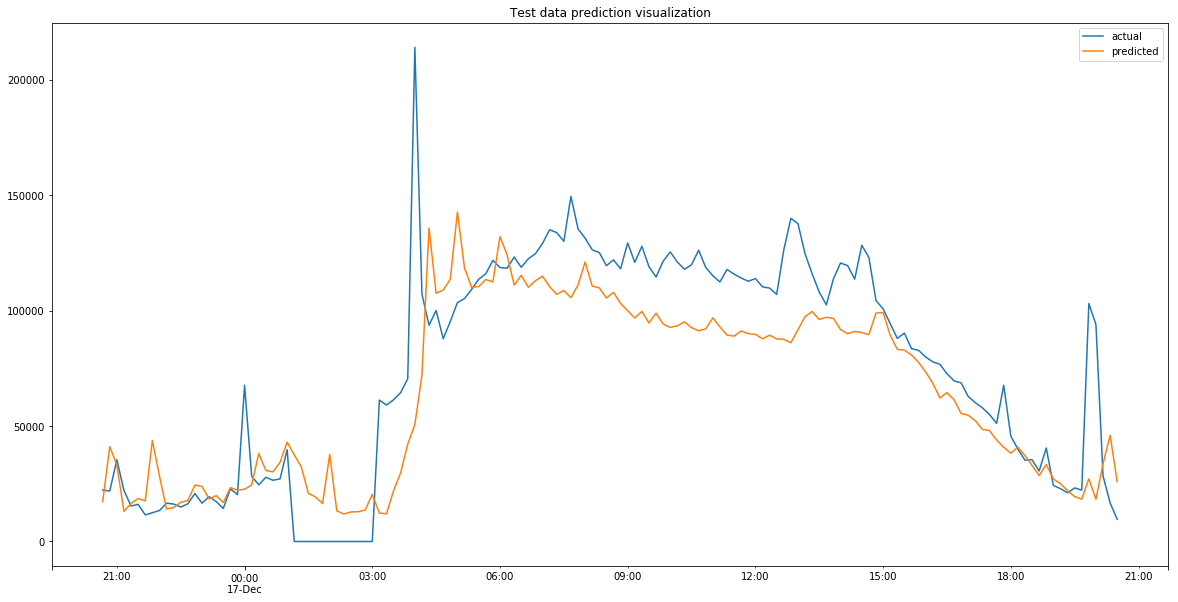

In [33]:
FROM = 0
TO = 6*24

actual[FROM:TO].plot(label='actual')
predicted[FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()